# Artificial Intelligence II - HW2

**Sakarellos Ioannis (sdi1800167)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def split_data(train, test, test_size=0.15):

  X_train = train[['url', 'review']]
  y_train = train[['rating']]

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, shuffle=True)

  if test != None:
    X_val = test[['url', 'review']]
    y_val = test[['rating']]

  return X_train.reset_index().drop('index', axis=1), X_val.reset_index().drop('index', axis=1), y_train.reset_index().drop('index', axis=1), y_val.reset_index().drop('index', axis=1)

In [ ]:
def process_data(X_data_set, y_data_set, remove_stop_words=False):

  X = X_data_set
  y = y_data_set

  X.drop('url', axis=1, inplace=True)
  X['review'] = X['review'].str.lower()

  X['review'].replace(r'<.*?>', ' ', regex=True, inplace=True)
  X['review'].replace(r'[^\w\s]', ' ', regex=True, inplace=True)
  X['review'].replace(r'\d', ' ', regex=True, inplace=True)
  X['review'].replace(r'\s+', ' ', regex=True, inplace=True)

  if remove_stop_words:
    nltk.download('stopwords')
    STOP_WORDS = stopwords.words('english')

    X['review'] = X['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

  y['label'] = y.apply(lambda row: 0 if row.rating < 5 else 1, axis=1)
  y.drop('rating', axis=1, inplace=True)

  return X.squeeze(), y.squeeze()

In [ ]:
def plot_curves(epoch, loss_val, loss_tr, prec_val, prec_tr, rec_val, rec_tr, f1_val, f1_tr):
  fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

  axs[0, 0].plot(epoch, loss_val)
  axs[0, 0].plot(epoch, loss_tr)
  axs[0, 0].set_ylim(bottom=0, top=1)
  axs[0, 0].legend(['Validation', 'Training'])
  axs[0, 0].set_title('Loss')

  axs[0, 1].plot(epoch, prec_val)
  axs[0, 1].plot(epoch, prec_tr)
  axs[0, 1].set_ylim(bottom=0, top=1)
  axs[0, 1].legend(['Validation', 'Training'])
  axs[0, 1].set_title('Precision Score')

  axs[1, 0].plot(epoch, rec_val)
  axs[1, 0].plot(epoch, rec_tr)
  axs[1, 0].set_ylim(bottom=0)
  axs[1, 0].legend(['Validation', 'Training'])
  axs[1, 0].set_title('Recall Score')

  axs[1, 1].plot(epoch, f1_val)
  axs[1, 1].plot(epoch, f1_tr)
  axs[1, 1].set_ylim(bottom=0)
  axs[1, 1].legend(['Validation', 'Training'])
  axs[1, 1].set_title('F1 Score')

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Artificial Intelligence II/imdb-reviews.csv', sep='\t')
test = None

train.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


In [ ]:
X_train_original, X_val_original, y_train_original, y_val_original = split_data(train, test)

In [ ]:
X_train, y_train = process_data(X_train_original, y_train_original, remove_stop_words=True)
X_val, y_val = process_data(X_val_original, y_val_original, remove_stop_words=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Transfrom Input Data to GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-12-31 16:20:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-31 16:20:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-31 16:20:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.300d.txt'
glove_d = 300

w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

In [ ]:
from gensim.models import KeyedVectors

keyed_vectors = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [ ]:
import numpy as np

X_train_glove = np.zeros((X_train.shape[0], glove_d))
X_val_glove = np.zeros((X_val.shape[0], glove_d))

for i in range(X_train.shape[0]):
  total = 0
  for word in X_train[i].split():
    if word in keyed_vectors:
      X_train_glove[i] += keyed_vectors[word]
      total += 1
  if total != 0:
    X_train_glove[i] /= total

for i in range(X_val.shape[0]):
  total = 0
  for word in X_val[i].split():
    if word in keyed_vectors:
      X_val_glove[i] += keyed_vectors[word]
      total += 1
  if total != 0:
    X_val_glove[i] /= total

y_train = np.array(y_train)
y_val = np.array(y_val)

## Define DataLoaders

In [ ]:
import torch

from torch.utils.data import Dataset, DataLoader

class trainDataSet(Dataset):
  def __init__(self):
    self.x = torch.Tensor(X_train_glove)
    self.y = torch.LongTensor(y_train)

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples


class valDataSet(Dataset):
  def __init__(self):
    self.x = torch.Tensor(X_val_glove)
    self.y = torch.LongTensor(y_val)

    self.n_samples = len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

trainLoader = DataLoader(dataset=trainDataSet(), batch_size=256, shuffle=True)
valLoader = DataLoader(dataset=valDataSet(), batch_size=256, shuffle=True)

## Create Neural Network

In [ ]:
import torch.nn as nn

class NN(nn.Module):
  def __init__(self, D_in, H1, H2, H3, D_out, activation, activationOUT=None):
    super(NN, self).__init__()

    self.activation = activation
    self.activationOUT = activationOUT

    self.fc1 = nn.Linear(D_in, H1)
    self.fc2 = nn.Linear(H1, H2)
    self.fc3 = nn.Linear(H2, H3)
    self.fc4 = nn.Linear(H3, D_out)

  def forward(self, x):
    h1 = self.activation(self.fc1(x))
    h2 = self.activation(self.fc2(h1))
    h3 = self.activation(self.fc3(h2))
    if self.activationOUT is not None:
      out = self.activationOUT(self.fc4(h3))
    else:
      out = self.activation(self.fc4(h3))

    return out

## Training Method

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def train_model(epochs, optimizer, dataloaderTRAIN, dataloaderVAL, cost_func, model, device='cpu', print_out=True):
  device = torch.device(device)

  list_loss_T = []
  list_loss_V = []

  list_f1_T = []
  list_f1_V = []

  list_precision_T = []
  list_precision_V = []

  list_recall_T = []
  list_recall_V = []

  list_epoch = []

  for epoch in range(epochs):
    if print_out:
      print('Epoch No ', epoch, '\n================', sep='')

    scores_TRAIN = []
    targets_TRAIN = []

    for batch, (data, targets) in enumerate(dataloaderTRAIN):
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)
      loss = cost_func(scores, targets)

      scores_TRAIN.append(scores)
      targets_TRAIN.append(targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if print_out:
        print('Batch No ', batch, ',\tloss is ', loss.item(), sep='')

    scores_TRAIN = torch.cat(scores_TRAIN, 0).cpu()
    targets_TRAIN = torch.cat(targets_TRAIN, 0).cpu()

    model.eval()

    scores_VAL = []
    targets_VAL = []

    with torch.no_grad():
      for data, targets in dataloaderVAL:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)

        scores_VAL.append(scores)
        targets_VAL.append(targets)

    scores_VAL = torch.cat(scores_VAL, 0).cpu()
    targets_VAL = torch.cat(targets_VAL, 0).cpu()

    model.train()

    _, pred_TRAIN = scores_TRAIN.max(1)

    loss_T = cost_func(scores_TRAIN, targets_TRAIN).item()
    f1_T = f1_score(targets_TRAIN, pred_TRAIN, average='macro')
    prec_T = precision_score(targets_TRAIN, pred_TRAIN)
    rec_T = recall_score(targets_TRAIN, pred_TRAIN)

    list_loss_T.append(loss_T)
    list_f1_T.append(f1_T)
    list_precision_T.append(prec_T)
    list_recall_T.append(rec_T)

    _, pred_VAL = scores_VAL.max(1)

    loss_V = cost_func(scores_VAL, targets_VAL).item()
    f1_V = f1_score(targets_VAL, pred_VAL, average='macro')
    prec_V = precision_score(targets_VAL, pred_VAL)
    rec_V = recall_score(targets_VAL, pred_VAL)

    list_loss_V.append(loss_V)
    list_f1_V.append(f1_V)
    list_precision_V.append(prec_V)
    list_recall_V.append(rec_V)

    list_epoch.append(epoch)

    if print_out:
      print('')

  return model, list_epoch, list_loss_T, list_loss_V, list_f1_T, list_f1_V, list_precision_T, list_precision_V, list_recall_T, list_recall_V

## Evaluation Method

In [ ]:
def eval_model(dataloader, cost_func, model, device='cpu'):
  device = torch.device(device)

  model.eval()
  with torch.no_grad():

    scores_all = []
    targets_all = []

    for data, targets in dataloader:
      data = data.to(device=device)
      targets = targets.to(device=device)

      scores = model(data)

      scores_all.append(scores)
      targets_all.append(targets)

    scores_all = torch.cat(scores_all, 0).cpu()
    targets_all = torch.cat(targets_all, 0).cpu()

    _, pred = scores_all.max(1)

    loss = cost_func(scores_all, targets_all)
    f1 = f1_score(targets_all, pred, average='macro')
    prec = precision_score(targets_all, pred)
    rec = recall_score(targets_all, pred)
    mat = confusion_matrix(targets_all, pred)

    print('Loss:\t\t\t', loss, '\n')
    print('F1 Macro-Averaged Score:', f1)
    print('Precision Score:\t', prec)
    print('Recall Score:\t\t', rec, '\n')
    print('Confusion Matrix:\n', mat, '\n')

  model.train()

## Trying Different Model Implementations

In [ ]:
import torch.nn.functional as F
import torch.optim as opt

### Different Activation Functions

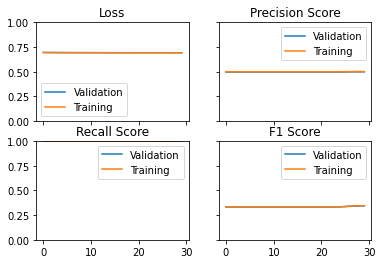

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.relu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

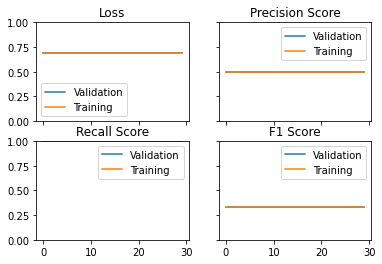

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.leaky_relu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

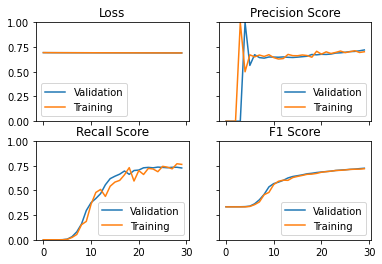

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.elu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

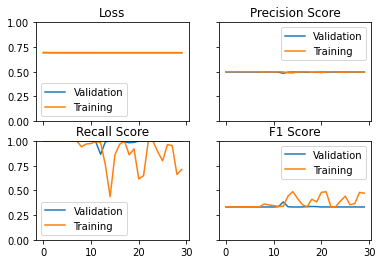

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.logsigmoid).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

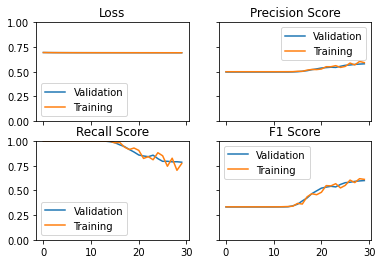

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.rrelu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

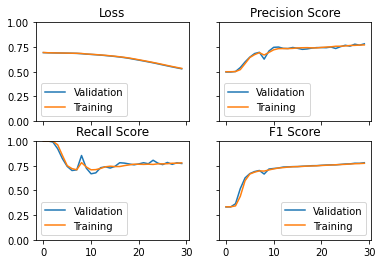

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

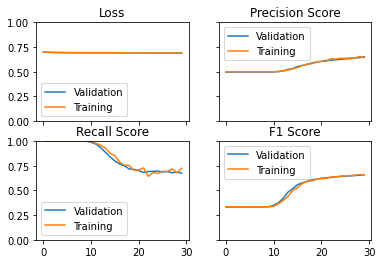

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.celu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

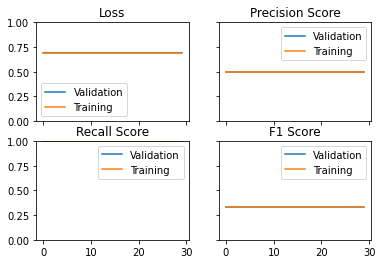

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.gelu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

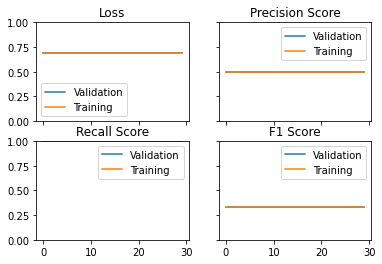

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=torch.sigmoid).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

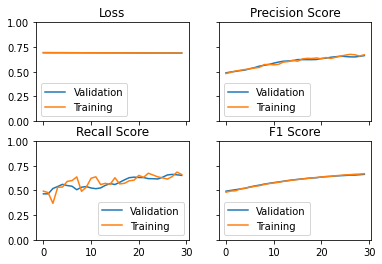

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=torch.tanh).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

### Different Learning Rates

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


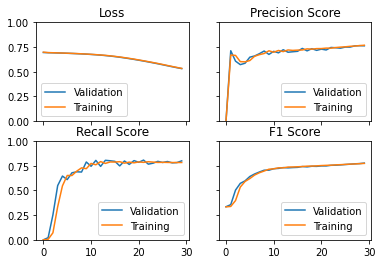

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

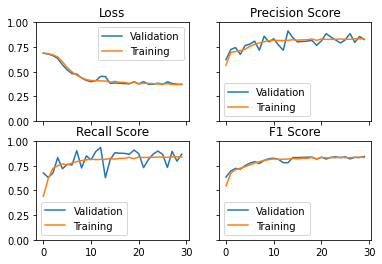

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.01
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

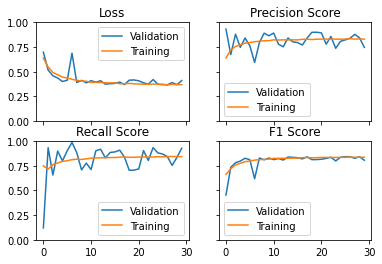

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.05
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

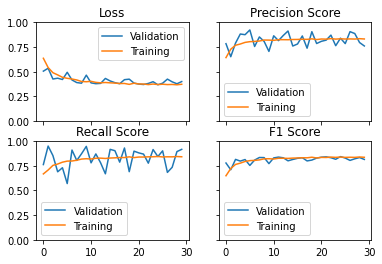

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.1
optimizer = opt.SGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

### Different Optimizer Functions

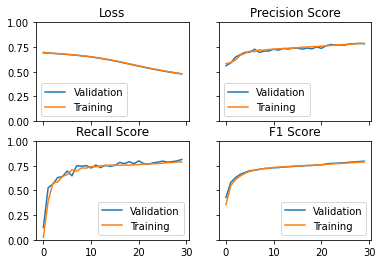

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.ASGD(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

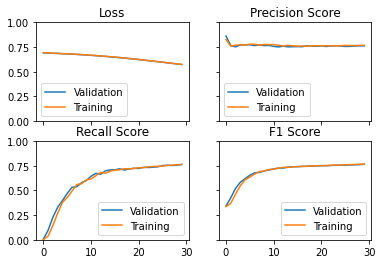

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adadelta(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

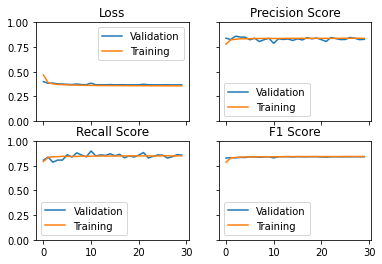

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

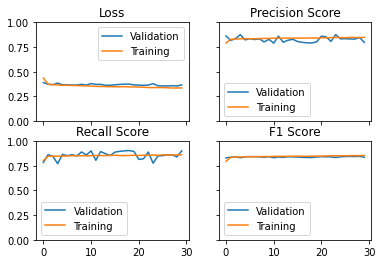

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adamax(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

### Different Number of Neurons per Layer

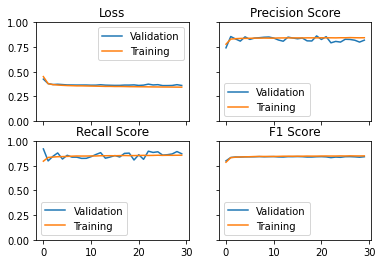

In [ ]:
model = NN(D_in=glove_d, H1=256, H2=256, H3=256, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

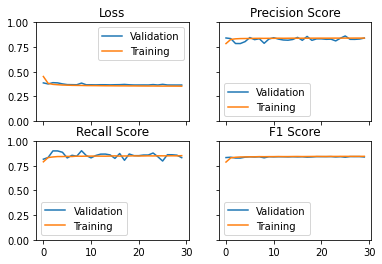

In [ ]:
model = NN(D_in=glove_d, H1=128, H2=128, H3=128, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

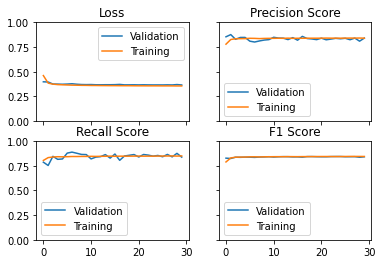

In [ ]:
model = NN(D_in=glove_d, H1=64, H2=64, H3=64, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

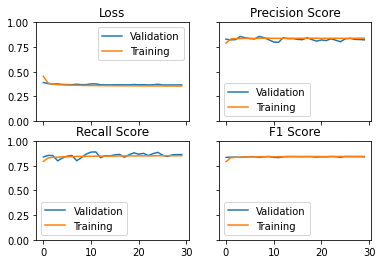

In [ ]:
model = NN(D_in=glove_d, H1=256, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cpu'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

### Trying on CUDA

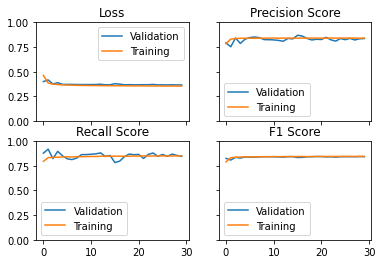

In [ ]:
model = NN(D_in=glove_d, H1=256, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cuda'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, device='cuda', print_out=False)

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

## Best Model

Epoch No 0
Batch No 0,	loss is 0.6944959163665771
Batch No 1,	loss is 0.6777809858322144
Batch No 2,	loss is 0.6783816814422607
Batch No 3,	loss is 0.6685957908630371
Batch No 4,	loss is 0.6624686121940613
Batch No 5,	loss is 0.6503507494926453
Batch No 6,	loss is 0.6443271636962891
Batch No 7,	loss is 0.6630144119262695
Batch No 8,	loss is 0.6537749171257019
Batch No 9,	loss is 0.6011902689933777
Batch No 10,	loss is 0.6051211953163147
Batch No 11,	loss is 0.5997405648231506
Batch No 12,	loss is 0.57572340965271
Batch No 13,	loss is 0.5587620139122009
Batch No 14,	loss is 0.5723289251327515
Batch No 15,	loss is 0.5601707100868225
Batch No 16,	loss is 0.5439579486846924
Batch No 17,	loss is 0.5387404561042786
Batch No 18,	loss is 0.5436493158340454
Batch No 19,	loss is 0.5352222323417664
Batch No 20,	loss is 0.5262680053710938
Batch No 21,	loss is 0.5371884107589722
Batch No 22,	loss is 0.563073992729187
Batch No 23,	loss is 0.5625783801078796
Batch No 24,	loss is 0.5069230198860168
Ba

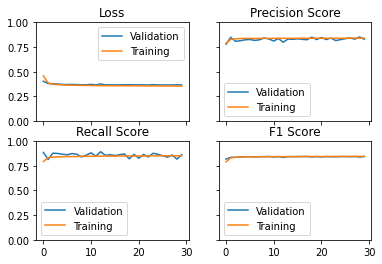

In [ ]:
model = NN(D_in=glove_d, H1=256, H2=64, H3=16, D_out=2, activation=F.selu).to(torch.device('cuda'))

epochs = 30
learning_rate = 0.002
optimizer = opt.Adagrad(model.parameters(), lr=learning_rate)
cost_func = nn.CrossEntropyLoss()

model, epochs, lossT, lossV, f1T, f1V, precisionT, precisionV, recallT, recallV = train_model(epochs=epochs, optimizer=optimizer, dataloaderTRAIN=trainLoader, dataloaderVAL=valLoader, cost_func=cost_func, model=model, device='cuda')

plot_curves(epochs, lossV, lossT, precisionV, precisionT, recallV, recallT, f1V, f1T)

In [ ]:
eval_model(dataloader=valLoader, cost_func=cost_func, model=model, device='cuda')

Loss:			 tensor(0.3662) 

F1 Macro-Averaged Score: 0.8422350404521066
Precision Score:	 0.8284650630011455
Recall Score:		 0.8612682345936291 

Confusion Matrix:
 [[2794  599]
 [ 466 2893]] 

